In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline, evaluate, accuracy
from surprise.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

In [17]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='|', names=r_cols, encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_dat', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',\
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror',\
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('data/ml-1m/movies.dat', sep='|', names=m_cols, encoding='latin-1')

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/ml-1m/users.dat', sep='|', names=u_cols, encoding='latin-1', parse_dates=True)

In [18]:
ratings['unix_timestamp'] = ratings['unix_timestamp'].apply(datetime.fromtimestamp)
ratings.columns = ['user_id', 'movie_id', 'rating', 'time']
ratings.head(10)

,user_id,movie_id,rating,time
0,1,1193,5,2000-12-31 20:12:40
1,1,661,3,2000-12-31 20:35:09
2,1,914,3,2000-12-31 20:32:48
3,1,3408,4,2000-12-31 20:04:35
4,1,2355,5,2001-01-06 21:38:11
5,1,1197,3,2000-12-31 20:37:48
6,1,1287,5,2000-12-31 20:33:59
7,1,2804,5,2000-12-31 20:11:59
8,1,594,4,2000-12-31 20:37:48
9,1,919,4,2000-12-31 20:22:48


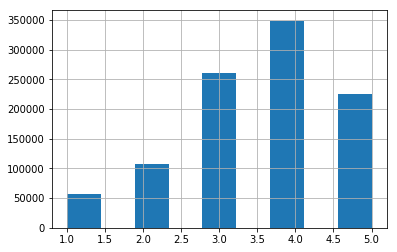

In [19]:
ratings['rating'].hist(bins=9)

In [20]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies.head(10)

KeyError: 'release_date'

In [21]:
for i in users['occupation'].unique():
    users[i] = users['occupation'] == i
users.drop('occupation', axis=1, inplace=True)
users.head(10)

,user_id,age,sex,zip_code,10,16,15,7,20,9,...,14,4,11,8,19,2,18,5,13,6
0,1,F,1,48067,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,M,56,70072,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,M,25,55117,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,M,45,02460,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,M,25,55455,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5,6,F,50,55117,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
6,7,M,35,06810,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,8,M,25,11413,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,9,M,25,61614,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,10,F,35,95370,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
ratings_movie_summary = ratings.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
ratings_movie_summary.head(10)

,count,mean,std
movie_id,,,
1,2077,4.146846,0.852349
2,701,3.201141,0.983172
3,478,3.016736,1.071712
4,170,2.729412,1.013381
5,296,3.006757,1.025086
6,940,3.878723,0.934588
7,458,3.410480,0.979918
8,68,3.014706,0.954059
9,102,2.656863,1.048290


In [23]:
ratings_user_summary = ratings.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
ratings_user_summary.head(10)

,count,mean,std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699
6,71,3.901408,0.830747
7,31,4.322581,0.747757
8,139,3.884892,0.925321
9,106,3.735849,0.820010


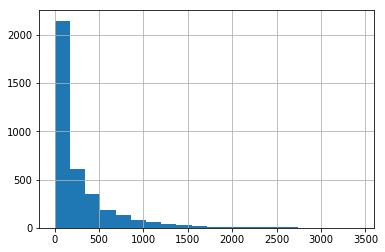

In [24]:
ratings_movie_summary.sort_values(by='count')['count'].hist(bins=20)

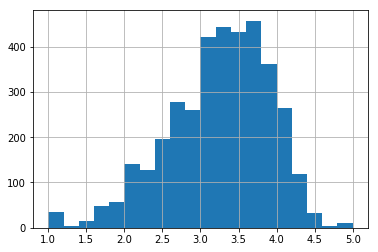

In [25]:
ratings_movie_summary.sort_values(by='mean')['mean'].hist(bins=20)

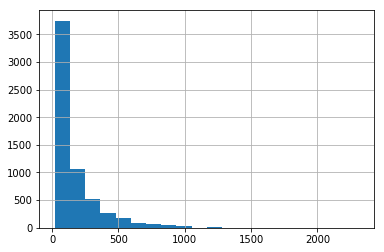

In [26]:
ratings_user_summary.sort_values(by='count')['count'].hist(bins=20)


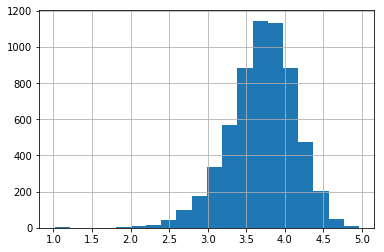

In [27]:
ratings_user_summary.sort_values(by='mean')['mean'].hist(bins=20)

In [28]:
ratings_p = pd.pivot_table(ratings, values='rating', index='user_id', columns='movie_id')
ratings_p.iloc[:10, :10]

movie_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
8,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
mean = ratings_p.stack().mean()
std = ratings_p.stack().std()

In [30]:
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
#data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/Users/josefernandotavares/anaconda3/envs/Booknando/lib/python3.7/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Users/josefernandotavares/anaconda3/envs/Booknando/lib/python3.7/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8725
MAE:  0.6855
------------
Fold 2
RMSE: 0.8749
MAE:  0.6867
------------
Fold 3
RMSE: 0.8739
MAE:  0.6861
------------
Fold 4
RMSE: 0.8727
MAE:  0.6855
------------
Fold 5
RMSE: 0.8731
MAE:  0.6857
------------
------------
Mean RMSE: 0.8734
Mean MAE : 0.6859
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8724787245437545,
                             0.874919639244117,
                             0.8738931613247085,
                             0.8726858610302667,
                             0.8730561108179863],
                            'mae': [0.6855039368180995,
                             0.6866621047969848,
                             0.6860696469345542,
                             0.6854607422443828,
                             0.685740360722391]})